<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [3]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-03-14 22:27:48--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2022-03-14 22:27:48 (302 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object


In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



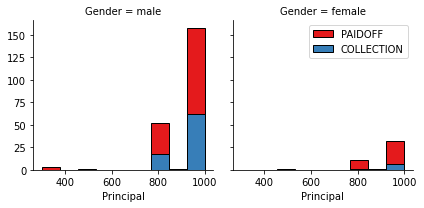

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

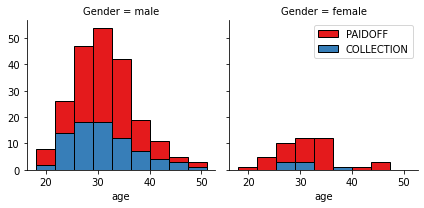

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


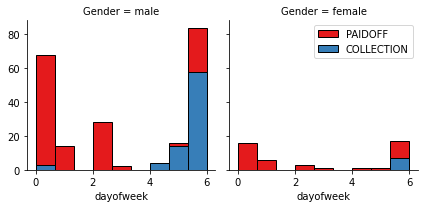

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [39]:
# First, it is necessary to split the train and test using sklearn. 80 percent of the data will be used for trainning, the rest for testing.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=4)
# print ('Train set sizes:', XTrain.shape,  yTrain.shape)
# print ('Test set sizes:', XTest.shape,  yTest.shape)

In [40]:
# Based on the testing and training data, different number of Ks will be tested until it gives the best result
kCandidates = 15
accuracyScoreKNeighbors = []
for k in range(1, kCandidates):
    # First create and train the model
    KNNmodel = KNeighborsClassifier(n_neighbors = k).fit(XTrain, yTrain)
    # Now predict the model
    yPredictedKNeighbors = KNNmodel.predict(XTest)
    # Save the accuracyScore
    accuracyScoreKNeighbors.append(metrics.accuracy_score(yTest, yPredictedKNeighbors))

# Now find the maximum accuracy 
print("The maximum level of accuracy ({:0.3f}) in KNN is found using {:0d} as k value".format(np.array(accuracyScoreKNeighbors).max(), np.array(accuracyScoreKNeighbors).argmax()+1))
KNNmodel = KNeighborsClassifier(n_neighbors = np.array(accuracyScoreKNeighbors).argmax()+1).fit(XTrain, yTrain)

The maximum level of accuracy (0.786) in KNN is found using 7 as k value


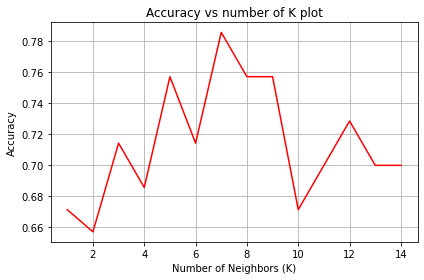

In [41]:
# Finally show the previous result in a more ilustrative way
plt.plot(range(1, kCandidates), accuracyScoreKNeighbors,'r')
plt.title(('Accuracy vs number of K plot'))
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Decision Tree


In [42]:
# Import libraries
from sklearn.tree import DecisionTreeClassifier

# The data has been previously split, so it will be used in order to compare the different approaches.
# In this case, the current implementation of the decision tree provides some conditions to chose the correct depth value, such as  
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=4)
loanTree = DecisionTreeClassifier(criterion="entropy").fit(XTrain, yTrain)
yPredictedTree = loanTree.predict(XTest)
accuracyScoreTree = metrics.accuracy_score(yTest, yPredictedTree)

print("The maximum level of accuracy ({:0.3f}) in Decision Tree is found using {:0d} as max depth value".format(accuracyScoreTree, loanTree.get_depth()))


The maximum level of accuracy (0.700) in Decision Tree is found using 17 as max depth value


In [43]:
# Now show a visualization of the data
!conda install -c conda-forge pydotplus -y
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
Feature.head()

Solving environment: done

# All requested packages already installed.



,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


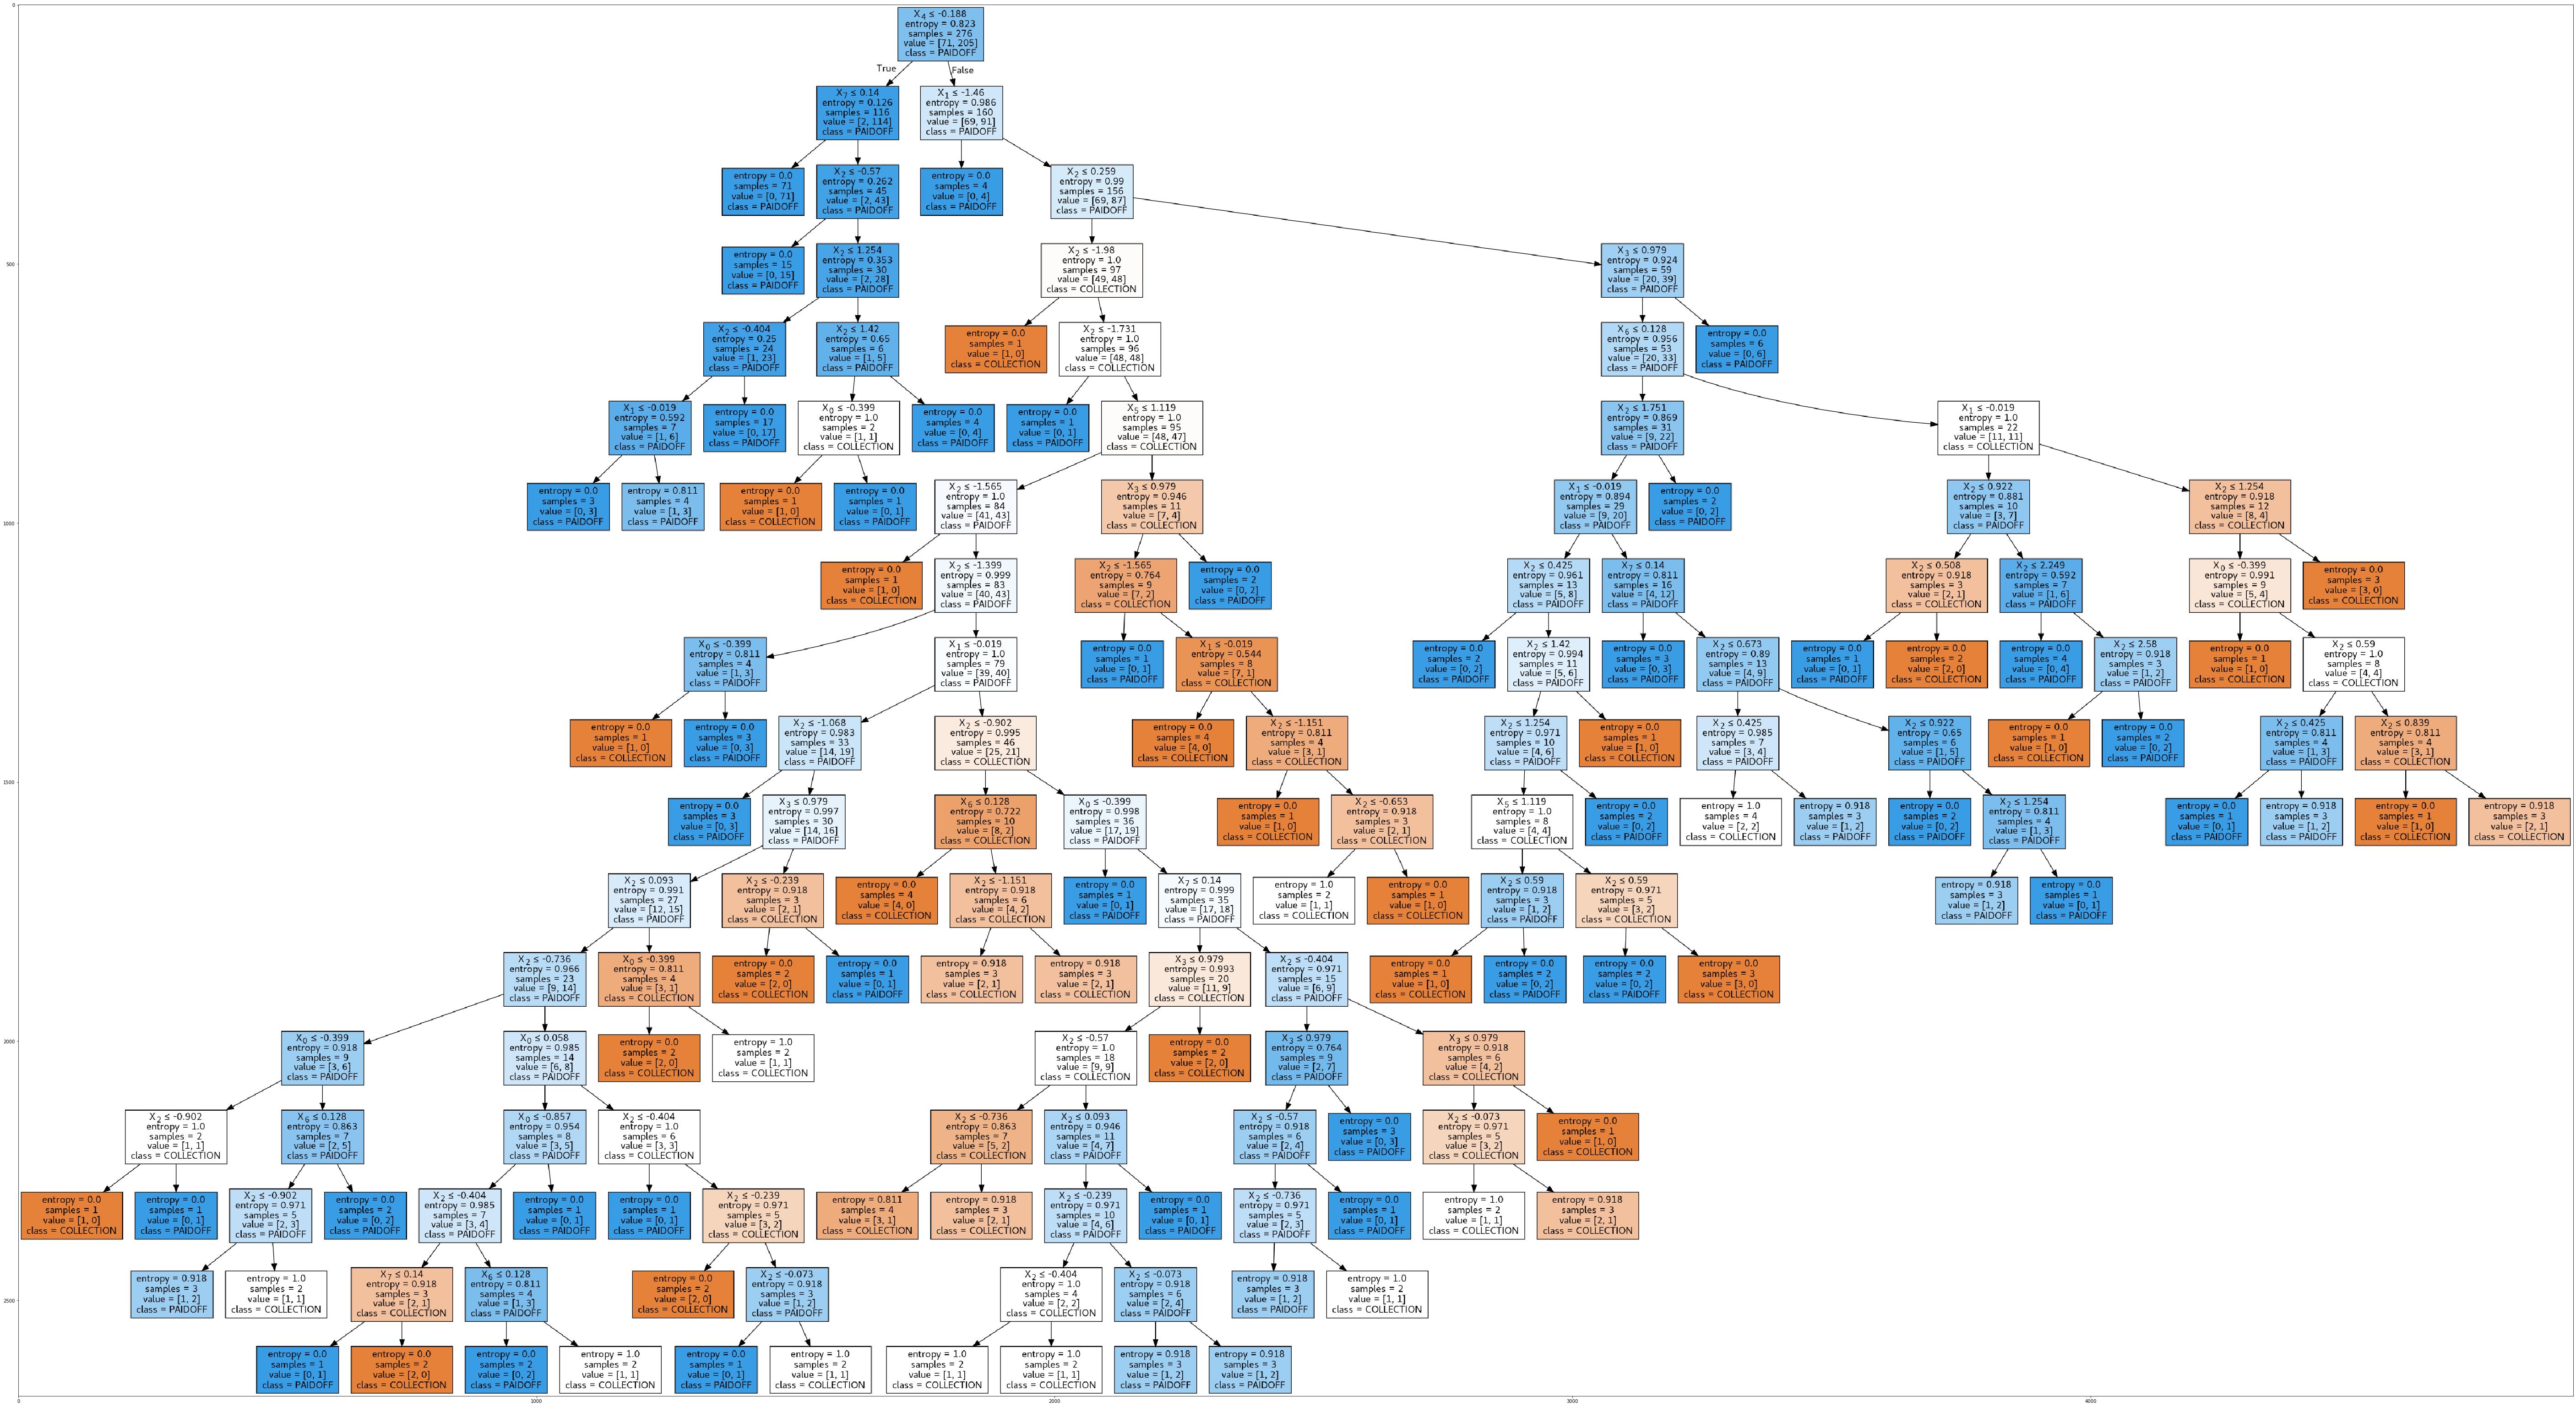

In [44]:
dotData = StringIO()
out=tree.export_graphviz(loanTree, out_file=dotData, class_names= np.unique(yTrain), filled=True,  special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dotData.getvalue())  
graph.write_png('loantree.png')
img = mpimg.imread('loantree.png')
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')


# Support Vector Machine


In [45]:
# First Import the 
from sklearn import svm

In [46]:
# Create classificator using different kernerls to find if there is a difference among them
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=4)

kernelling = ['linear', 'poly', 'rbf', 'sigmoid']
accuracyScoreSVM = []
f1ScoreSVM = []
jaccardScoreSVM = []
for kernelFunction in kernelling:
    svmLoan = svm.SVC(kernel=kernelFunction).fit(XTrain, yTrain)
    yPredictedSVM = svmLoan.predict(XTest)
    accuracyScoreSVM.append(metrics.accuracy_score(yTest, yPredictedSVM))

In [47]:
print(accuracyScoreSVM)
print("The maximum level of accuracy ({:0.3f}) in SVM is found using {:s} as kerneling function".format(np.array(accuracyScoreSVM).max(), kernelling[np.array(accuracyScoreSVM).argmax()]))
svmLoan = svm.SVC(kernel=kernelling[np.array(accuracyScoreSVM).argmax()]).fit(XTrain, yTrain)

[0.7857142857142857, 0.7714285714285715, 0.7428571428571429, 0.7428571428571429]
The maximum level of accuracy (0.786) in SVM is found using linear as kerneling function


# Logistic Regression


In [48]:
# Load the necessary libraries
from sklearn.linear_model import LogisticRegression

In [49]:
# Using liblinear solver since it is recommended for small datasets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=4)
logisticRegressionLoan = LogisticRegression(C=0.01, solver='liblinear').fit(XTrain, yTrain)
yPredictedLogisticRegression = logisticRegressionLoan.predict(XTest)

In [50]:
accuracyScoreLogisticRegression = metrics.accuracy_score(yTest, yPredictedLogisticRegression)
print("The accuracy score in logistic regression is ({:0.3f})".format(accuracyScoreLogisticRegression))

The accuracy score in logistic regression is (0.686)


# Model Evaluation using Test set


In [51]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [52]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-03-14 22:38:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-03-14 22:38:05 (44.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [53]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [54]:
# Preprocess the data in the same way as done before
## First focus on the day of the week
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x > 3)  else 0)

## Then prepare the gender
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
FeaturesTest = test_df[['Principal','terms','age','Gender','weekend']]

## Now continue with the education
FeaturesTest = pd.concat([FeaturesTest, pd.get_dummies(test_df['education'])], axis=1)
FeaturesTest.drop(['Master or Above'], axis = 1,inplace=True)
FeaturesTest.head()

XTest = FeaturesTest
YTest = test_df['loan_status'].values

# Finally normalize the data
XTest= preprocessing.StandardScaler().fit(XTest).transform(XTest)

In [55]:
# Predict vaues with the different classifiers
YPredictedTestKNN = KNNmodel.predict(XTest)
YPredictedTestDecisionTree = loanTree.predict(XTest)
YPredictedTestSVM = svmLoan.predict(XTest)
YPredictedTestLogisticRegression = logisticRegressionLoan.predict(XTest)
YProbabilityLogisticRegression = logisticRegressionLoan.predict_proba(XTest)

In [57]:
# Finally Calculate the metrics, use the average as weighted to  have a single metric for both clases

JaccardKNN = jaccard_score(YTest, YPredictedTestKNN, average = 'weighted')
JaccardDecisionTree = jaccard_score(YTest, YPredictedTestDecisionTree, average='weighted')
JaccardSVM = jaccard_score(YTest, YPredictedTestSVM, average='weighted')
JaccardLogisticRegression = jaccard_score(YTest, YPredictedTestLogisticRegression, average='weighted')
print("Jaccard KNN: ", JaccardKNN)
print("Jaccard Decision Tree: ", JaccardDecisionTree)
print("Jaccard SVM: ", JaccardSVM)
print("Jaccard Logistic Regression: ", JaccardLogisticRegression)

F1KNN = f1_score(YTest, YPredictedTestKNN, average='weighted')
F1DecisionTree = f1_score(YTest, YPredictedTestDecisionTree, average='weighted')
F1SVM = f1_score(YTest, YPredictedTestSVM, average='weighted')
F1LogisticRegression = f1_score(YTest, YPredictedTestLogisticRegression, average='weighted')
print("F1-score KNN: ", F1KNN)
print("F1-score Decision Tree: ", F1DecisionTree)
print("F1-score SVM: ", F1SVM)
print("F1-score Logistic Regression: ", F1LogisticRegression)


LogLossLogisticRegression = log_loss(YTest, YProbabilityLogisticRegression)
print("LogLoss Logistic Regression: ", LogLossLogisticRegression)

Jaccard KNN:  0.5258659469185786
Jaccard Decision Tree:  0.43874441817704224
Jaccard SVM:  0.5486968449931412
Jaccard Logistic Regression:  0.5486968449931412
F1-score KNN:  0.6453810131971051
F1-score Decision Tree:  0.5988805707115566
F1-score SVM:  0.6304176516942475
F1-score Logistic Regression:  0.6304176516942475
LogLoss Logistic Regression:  0.6037871272191607


# Report

You should be able to report the accuracy of the built model using different evaluation metrics (the values might be different given that the models are trained with different samples every time):


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.52586 | 0.64538  | NA      |
| Decision Tree      | 0.43874 | 0.59888  | NA      |
| SVM                | 0.54869 | 0.63041  | NA      |
| LogisticRegression | 0.54869 |0.63041   | 0.60378 |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
